Homework 7 <br>
Sam Odle

In [38]:
import torch
from torch.backends import cudnn
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import random
import pandas as pd
from timeit import default_timer as timer


GPU Implementation

In [39]:
# Whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = torch.cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

CUDA_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(CUDA_DEVICE)


print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__CUDA Device Name:',torch.cuda.get_device_name(0))
print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)


Train on gpu: True
1 gpus detected.
cuda
__CUDNN VERSION: 8200
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 2080 Ti
__CUDA Device Total Memory [GB]: 11.810832384


Correctly pre-processes images into train, validation, and holdout by randomly specifying indicies and feeding these to torch.utils.data.sampler.SubsetRandomSampler

Correctly adds applicable data augmentations to your DataLoader

In [40]:
from torch.utils.data import SubsetRandomSampler
num_workers = 1
pin_memory = True
batch_size = 32
valid_size = 0.1

valid_transform = transforms.Compose([
        transforms.Resize(size=[224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ])

main_dataset = datasets.ImageFolder(root='images/', transform=valid_transform)

num_images = len(main_dataset)
indices = list(range(num_images))
n_test = int( num_images * .1 )  # number of test/val elements
n_train = num_images - 2 * n_test

np.random.seed(42)
idx = list(range(num_images))  # indices to all elements
random.shuffle(idx)  # in-place shuffle the indices

train_idx = idx[:n_train]
valid_idx = idx[n_train:(n_train + n_test)]
test_idx = idx[(n_train + n_test):]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler= SubsetRandomSampler(test_idx)



train_transforms = [
    transforms.Resize(size=[224,224]),
    transforms.RandomRotation(degrees=90),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # Imagenet standards
]


train_loader = torch.utils.data.DataLoader(
    main_dataset,  batch_size=batch_size, sampler=train_sampler,
    num_workers=num_workers, pin_memory=pin_memory, drop_last=False
)

test_loader = torch.utils.data.DataLoader(
    main_dataset,  batch_size=batch_size, sampler=test_sampler,
    num_workers=num_workers, pin_memory=pin_memory, drop_last=False
)

valid_loader = torch.utils.data.DataLoader(
    main_dataset,  batch_size=batch_size, sampler=valid_sampler,
    num_workers=num_workers, pin_memory=pin_memory, drop_last=False
)

train_loader.dataset.transforms = train_transforms

Correctly download and instantiate a CNN pre-trained on ImageNet

In [41]:
model = torchvision.models.vgg16(pretrained=True)
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False
n_inputs = model.classifier[6].in_features

# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 2), nn.LogSoftmax(dim=1)) #change from LogSoftmax(dim=1) to Softmax

# Move to gpu and parallelize
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

Correctly fine-tune that CNN on your blood cell images using training and validation

Implemented from https://github.com/WillKoehrsen/pytorch_challenge/blob/master/Transfer%20Learning%20in%20PyTorch.ipynb

In [42]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [43]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=.001)
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    valid_loader,
    save_file_name='file_save_name',
    max_epochs_stop=20,
    n_epochs=30,
    print_every=1)

Starting Training from Scratch.

Epoch: 0	100.00% complete. 46.08 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 0.2789 	Validation Loss: 0.0279
		Training Accuracy: 68.01%	 Validation Accuracy: 8.86%
Epoch: 1	100.00% complete. 46.39 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.2474 	Validation Loss: 0.0240
		Training Accuracy: 69.78%	 Validation Accuracy: 9.02%
Epoch: 2	100.00% complete. 46.29 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.2439 	Validation Loss: 0.0235
		Training Accuracy: 69.90%	 Validation Accuracy: 9.15%
Epoch: 3	100.00% complete. 45.15 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.2426 	Validation Loss: 0.0247
		Training Accuracy: 69.91%	 Validation Accuracy: 9.00%
Epoch: 4	100.00% complete. 45.09 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.2396 	Validation Loss: 0.0235
		Training Accuracy: 70.11%	 Validation Accuracy: 9.01%
Epoch: 5	100.00% complete. 44.85 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.2376 	Validation Loss

Text(0.5, 1.0, 'Training and Validation Losses')

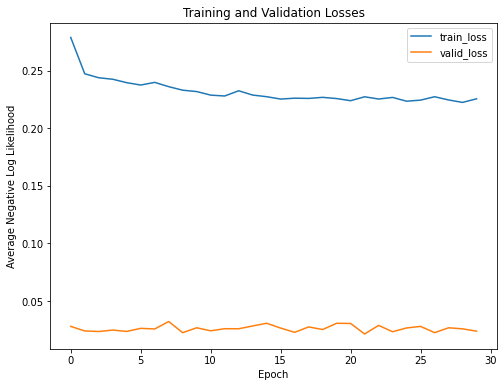

In [44]:

plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

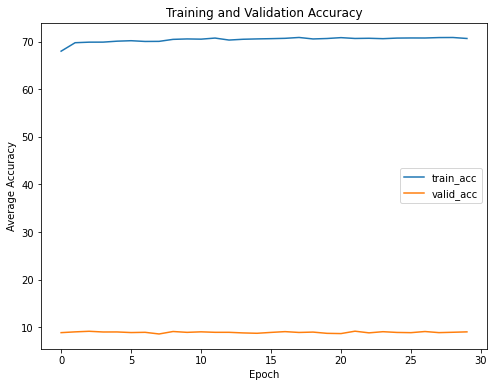

In [45]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')


Report your results on the holdout set

In [46]:
holdout_loss = 0.0
holdout_acc = 0

#test_loader.dataset.t

with torch.no_grad():
    # Set to evaluation mode
    model.eval()

    # Validation loop
    for data, target in test_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Forward pass
        output = model(data)

        # Validation loss
        loss = criterion(output, target)
        # Multiply average loss times the number of examples in batch
        holdout_loss += loss.item() * data.size(0)

        # Calculate validation accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples
        holdout_acc += accuracy.item() * data.size(0)

    # Calculate average losses
    holdout_loss = holdout_loss / len(test_loader.dataset)

    # Calculate average accuracy
    holdout_acc = holdout_acc / len(test_loader.dataset)
    holdout_acc = round(holdout_acc*100, 2)

print(f'Holdout Accuracy: {holdout_acc}%')

Holdout Accuracy: 8.97%
